# Problem Statement
Motivation:    
In pandemics and overwhelmed health system, the possible of  limitation to perform tests to detect SARS-CoV-2 and test every case would be impractical. Tests results could be delayed even if  small sample of population would be tested.    
Objective:    
Predicting the chances of being positive or negative for covid19 and identify the factors that influence it. Provide the recommendations to the hospital on how they can better manage the admission of patients to the general ward, semi-intensive unit, or intensive care unit.



In [237]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)

# this will help in making the Python code more structured automatically (help adhere to good coding practices)
%load_ext nb_black
import pandas as pd 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
import numpy as np
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    precision_recall_curve,
    roc_curve,
    make_scorer)
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold,SelectKBest,chi2
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier 
from scipy import stats
sns.set_context('talk',font_scale=0.7)
sns. set_style('ticks')


The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

# Functions 

In [238]:

#function to test the binary features
def is_binary(series, allow_na=False):
    if allow_na:
        series.dropna(inplace=True)
    return sorted(series.value_counts().index) == [0, 1]
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtypes)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

# function to plot a boxplot and a histogram along the same scale.

sns.set_theme('talk')
sns.set_style('white')
def histogram_boxplot(df, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=df, x=feature, ax=ax_box2, showmeans=True, color="red"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=df, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="rgb"
    ) if bins else sns.histplot(
        data=df, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        df[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        df[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
    f2.savefig(f'{feature}_hist.png',dpi=200)

# function to create labeled barplots

sns.set_theme('talk')
sns.set_style('white')
def labeled_barplot(df, feature, perc=True, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(df[feature])  # length of the column
    count = df[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=df,
        x=feature,
        
        palette="Paired",
        order=df[feature].value_counts().sort_values(ascending=False).index[:n]
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
            
        )  # annotate the percentage

    plt.show()  # show the plot
    
def stacked_barplot(data, predictor, target,color=['black','red']):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
   
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5),color=color)
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.xlabel('{}'.format(predictor.replace('_',' ').title()))
    plt.ylabel('{}'.format(target.replace('_',' ').title()))
    
    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 24

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.savefig(predictor+target+'_stakedbars.png',bbox_inches='tight') # save
    plt.show() 
def confusion_matrix_statsmodels(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    y_pred = model.predict(predictors) > threshold
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification_statsmodels(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # checking which probabilities are greater than threshold
    pred_temp = model.predict(predictors) > threshold
    # rounding off the above values to get classes
    pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf           
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df
def remove_correlated_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    print(drops)
    x = x.drop(columns=drops)

    return x

def get_mean_encoding(df, group, target):
    """Group a Pandas DataFrame by a given column and return the mean encoding of the target variable for that grouping.
    
    Args:
        :param df: Pandas DataFrame.
        :param group: Column to group by. 
        :param target: Target variable column.
        
    Returns:
        Mean for the target variable across the group.
    
    Example: 
        df['mean_encoding_postcode_area'] = get_mean_encoding(df, 'postcode_area', 'attended')
    """
    
    mean_encoded = df.groupby(group)[target].mean()
    return df[group].map(mean_encoded)

<IPython.core.display.Javascript object>

# importing dataset and the data description 

In [239]:
#reading excel file to data frame
df=pd.read_excel('covid19_dataset.xlsx', sheet_name=0, engine='openpyxl')

<IPython.core.display.Javascript object>

In [240]:
print(f'the shape of the dataset: {df.shape}') 

the shape of the dataset: (5644, 111)


<IPython.core.display.Javascript object>

In [241]:
# data type 
df.dtypes.value_counts()

float64    70
object     37
int64       4
dtype: int64

<IPython.core.display.Javascript object>

In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 111 entries, Patient ID to ctO2 (arterial blood gas analysis)
dtypes: float64(70), int64(4), object(37)
memory usage: 4.8+ MB


<IPython.core.display.Javascript object>

In [243]:
# Editing the features name to become shorter
clean_cols=[col.replace(' ','_').replace('/','_').strip() for col in df.columns.tolist()]
print(len(clean_cols),len(set(clean_cols)))


111 111


<IPython.core.display.Javascript object>

In [244]:
df.columns=clean_cols
print(df.columns.values)

['Patient_ID' 'Patient_age_quantile' 'SARS-Cov-2_exam_result'
 'Patient_addmited_to_regular_ward_(1=yes,_0=no)'
 'Patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)'
 'Patient_addmited_to_intensive_care_unit_(1=yes,_0=no)' 'Hematocrit'
 'Hemoglobin' 'Platelets' 'Mean_platelet_volume_' 'Red_blood_Cells'
 'Lymphocytes' 'Mean_corpuscular_hemoglobin_concentration\xa0(MCHC)'
 'Leukocytes' 'Basophils' 'Mean_corpuscular_hemoglobin_(MCH)'
 'Eosinophils' 'Mean_corpuscular_volume_(MCV)' 'Monocytes'
 'Red_blood_cell_distribution_width_(RDW)' 'Serum_Glucose'
 'Respiratory_Syncytial_Virus' 'Influenza_A' 'Influenza_B'
 'Parainfluenza_1' 'CoronavirusNL63' 'Rhinovirus_Enterovirus'
 'Mycoplasma_pneumoniae' 'Coronavirus_HKU1' 'Parainfluenza_3'
 'Chlamydophila_pneumoniae' 'Adenovirus' 'Parainfluenza_4'
 'Coronavirus229E' 'CoronavirusOC43' 'Inf_A_H1N1_2009'
 'Bordetella_pertussis' 'Metapneumovirus' 'Parainfluenza_2' 'Neutrophils'
 'Urea' 'Proteina_C_reativa_mg_dL' 'Creatinine' 'Potassium' 'Sodium'
 'In

<IPython.core.display.Javascript object>

In [245]:
#drop old index and meaningless columns 
df.drop(['Patient_ID'],axis=1,inplace=True)

<IPython.core.display.Javascript object>

<AxesSubplot:>

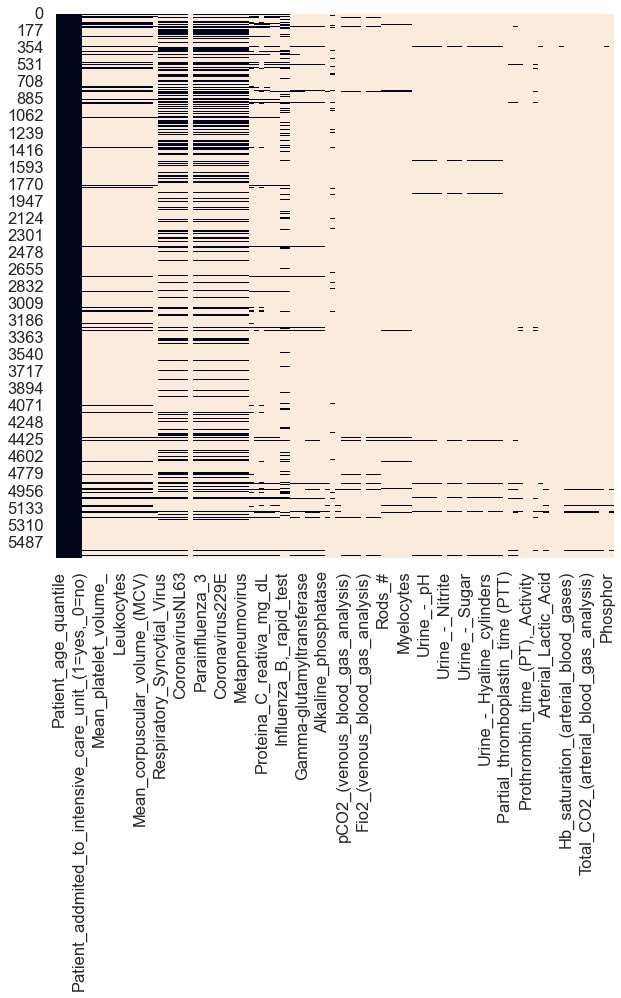

<IPython.core.display.Javascript object>

In [246]:
plt.figure(figsize=(10,10))
sns.heatmap(df.isna(), cbar=False)

In [247]:
numeric_features=df.describe().T[(df.describe().T['max'].values != 1.0 )].index.to_list()
categorical_features=df.describe(include='all').T[(df.describe(include='all').T['max'].values == 1.0) | (df.describe(include='all').T['unique'].values <33)].index.values
df[categorical_features].astype('category')

,SARS-Cov-2_exam_result,"Patient_addmited_to_regular_ward_(1=yes,_0=no)","Patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","Patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",Respiratory_Syncytial_Virus,Influenza_A,Influenza_B,Parainfluenza_1,CoronavirusNL63,Rhinovirus_Enterovirus,...,Urine_-_Ketone_Bodies,Urine_-_Nitrite,Urine_-_Urobilinogen,Urine_-_Protein,Urine_-_Leukocytes,Urine_-_Crystals,Urine_-_Hyaline_cylinders,Urine_-_Granular_cylinders,Urine_-_Yeasts,Urine_-_Color
0,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,negative,0,0,0,not_detected,not_detected,not_detected,not_detected,not_detected,detected,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,negative,0,0,0,not_detected,not_detected,not_detected,not_detected,not_detected,detected,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,positive,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,absent,NaN,normal,absent,29000,Ausentes,absent,absent,absent,yellow


<IPython.core.display.Javascript object>

In [248]:
# the classes of each object feature including the Nan values
for col in categorical_features:
    
    print(f'{col}........{df[col].value_counts(dropna=False).to_dict()}')

SARS-Cov-2_exam_result........{'negative': 5086, 'positive': 558}
Patient_addmited_to_regular_ward_(1=yes,_0=no)........{0: 5565, 1: 79}
Patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)........{0: 5594, 1: 50}
Patient_addmited_to_intensive_care_unit_(1=yes,_0=no)........{0: 5603, 1: 41}
Respiratory_Syncytial_Virus........{nan: 4290, 'not_detected': 1302, 'detected': 52}
Influenza_A........{nan: 4290, 'not_detected': 1336, 'detected': 18}
Influenza_B........{nan: 4290, 'not_detected': 1277, 'detected': 77}
Parainfluenza_1........{nan: 4292, 'not_detected': 1349, 'detected': 3}
CoronavirusNL63........{nan: 4292, 'not_detected': 1307, 'detected': 45}
Rhinovirus_Enterovirus........{nan: 4292, 'not_detected': 973, 'detected': 379}
Coronavirus_HKU1........{nan: 4292, 'not_detected': 1332, 'detected': 20}
Parainfluenza_3........{nan: 4292, 'not_detected': 1342, 'detected': 10}
Chlamydophila_pneumoniae........{nan: 4292, 'not_detected': 1343, 'detected': 9}
Adenovirus........{nan: 4292, '

<IPython.core.display.Javascript object>

Text(0, 0.5, 'count')

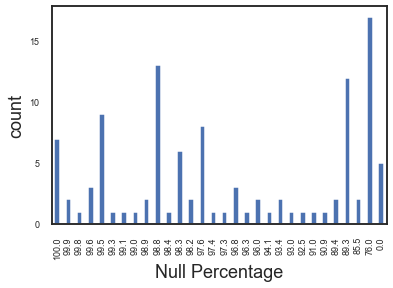

<IPython.core.display.Javascript object>

In [249]:
# select features with 99% null values
nan_count=df.isna().sum().sort_values(ascending=False)
nan_count.name='count'
perc_count=round(100*nan_count/df[numeric_features].shape[0],1)
perc_count.value_counts().sort_index(ascending=False).plot.bar(fontsize=9)
plt.xlabel('Null Percentage')
plt.ylabel('count')

<AxesSubplot:>

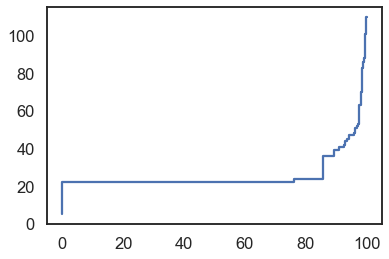

<IPython.core.display.Javascript object>

In [250]:
# plot comulitive sum of percentage of nan values
perc_count.value_counts().sort_index(ascending=True).cumsum().plot.line(x='index',drawstyle='steps')

In [251]:
num_col_90=perc_count[perc_count<99].index.values
len(num_col_90)

85

<IPython.core.display.Javascript object>

In [252]:
data=df[num_col_90]
data.shape

(5644, 85)

<IPython.core.display.Javascript object>

<AxesSubplot:>

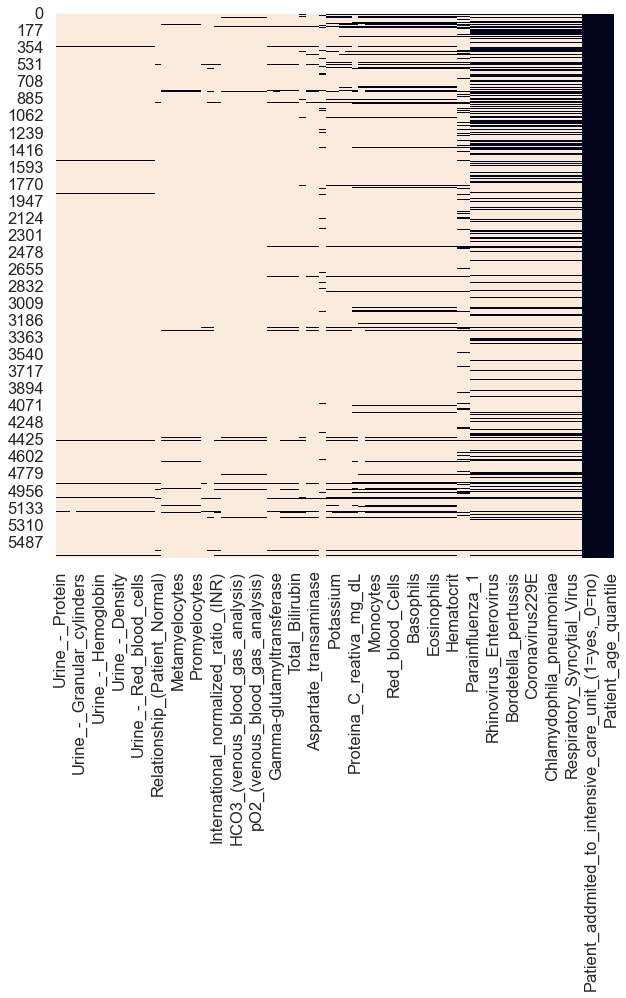

<IPython.core.display.Javascript object>

In [253]:
plt.figure(figsize=(10,10))
sns.heatmap(data.isna(), cbar=False)

In [254]:
col1=data[data.columns[data.columns.isin(numeric_features)]].columns.values
col2=data[data.columns[data.columns.isin(categorical_features)]].columns.values

<IPython.core.display.Javascript object>

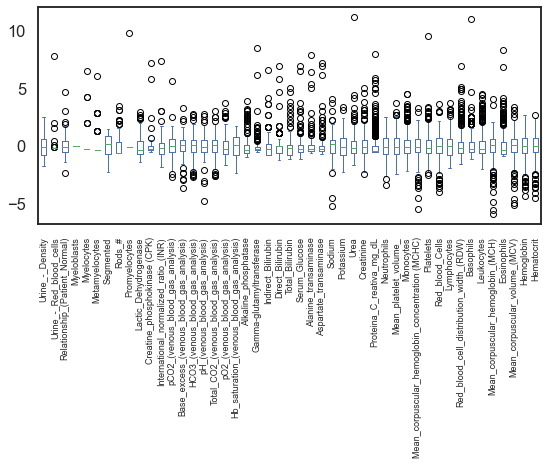

<IPython.core.display.Javascript object>

In [255]:
data[col1].drop('Patient_age_quantile',axis=1).plot.box(figsize=(9,4))
plt.xticks(rotation=90,fontsize=9);

# Preprocessing 
## Encoding and Imputing Missing values 

In [256]:
# first we relabel all the classes in object features with 0 or 1. 
labels = {'positive': 1, 
        'negative': 0,
        'detected': 1, 
        'not_detected': 0,
        'not_done': np.NaN,
        'Não Realizado': np.NaN,
        'absent': 0, 
        'present': 1,
        'detected': 1, 
        'not_detected': 0,
        'normal': 1,
        'light_yellow': 1, 
        'yellow': 2, 
        'citrus_yellow': 3, 
        'orange': 4,
        'clear': 1, 
        'lightly_cloudy': 2, 
        'cloudy': 3, 
        'altered_coloring': 4,
        '<1000': 1000,
        'Ausentes': 0, 
        'Urato Amorfo --+': 1, 
        'Oxalato de Cálcio +++': 1,
        'Oxalato de Cálcio -++': 1, 
        'Urato Amorfo +++': 1
}

data1 = data.copy()
data2 = data1.replace(labels)




<IPython.core.display.Javascript object>

In [257]:
# create an object for KNNImputer and imputing the most frequent values of the data after grouping by positive covid test 
col_cat=data2.columns[data2.columns.isin(categorical_features)]
imputer = KNNImputer(n_neighbors=7)
imputer_cat = pd.DataFrame(imputer.fit_transform(data2[col_cat]),columns=data2[col_cat].columns.tolist())
imputer_cat[imputer_cat<0.5]=0
imputer_cat[imputer_cat>=0.5]=1



<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='Frequency'>

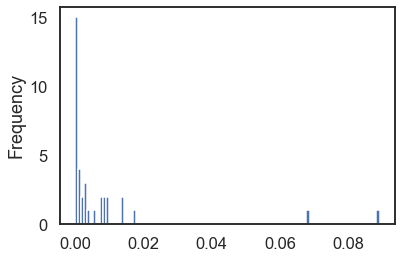

<IPython.core.display.Javascript object>

In [258]:
imputer_cat.apply(lambda X:X.var()).sort_values(ascending=True).plot.hist(bins=100)

In [259]:
col_num=data2.columns[data2.columns.isin(numeric_features)]
imputer = KNNImputer(n_neighbors=7)
imputer_num = pd.DataFrame(imputer.fit_transform(data2[col_num]),columns=data2[col_num].columns.tolist())

<IPython.core.display.Javascript object>

In [260]:
# adding numeric an categorical data to create new dataframe
imputer_x=pd.concat([imputer_num,imputer_cat],axis=1)
imputer_x.shape

(5644, 85)

<IPython.core.display.Javascript object>

### Feature Engineering 

In [261]:
#quantiling the Age quantiles feature
imputer_x['Age_quantile']=pd.cut(imputer_x['Patient_age_quantile'],bins=[0,4,9,14,19],labels=['0-4','4-9','9-14','14-19'])
imputer_x=imputer_x.drop(['Patient_age_quantile'],axis=1)

<IPython.core.display.Javascript object>

In [262]:
# get the one hot coding 
imputer_x=pd.get_dummies(imputer_x,columns=['Age_quantile'],drop_first=True)

<IPython.core.display.Javascript object>

In [263]:
data=imputer_x

<IPython.core.display.Javascript object>

In [264]:
# melting the patient admission to hospital in one column for EDA Porpose 

eda=pd.DataFrame()

def admission(df):
    if df['Patient_addmited_to_intensive_care_unit_(1=yes,_0=no)'] == 1:
        return 'Intensive_care'
    elif df['Patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)'] == 1:
        return 'Semi-intensive_care'
    elif df['Patient_addmited_to_regular_ward_(1=yes,_0=no)'] == 1:
        return 'Regular_ward'
    else:
        return 'No admission'
eda['admission']= data.apply(admission,axis=1)  

<IPython.core.display.Javascript object>

In [265]:
#list of numerical features
col11=list(col1)
col11.remove('Patient_age_quantile')


<IPython.core.display.Javascript object>

Text(0, 0.5, '')

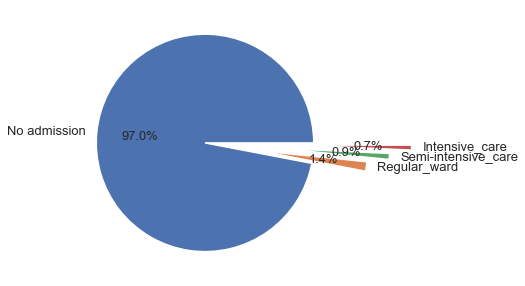

<IPython.core.display.Javascript object>

In [266]:
# eda analysis for numerical features
eda[col11]=data[col11]
eda['SARS-Cov-2_exam_result']=data['SARS-Cov-2_exam_result']
pie_plot=eda['admission'].value_counts().plot.pie(fontsize=13,figsize=(5,5),explode=[0,0.5,0.7,0.9],startangle=0,autopct='%1.1f%%')
pie_plot.set_ylabel('')


In [267]:
eda['admission'].value_counts().index

Index(['No admission', 'Regular_ward', 'Semi-intensive_care',
       'Intensive_care'],
      dtype='object')

<IPython.core.display.Javascript object>

## Select features 

<AxesSubplot:>

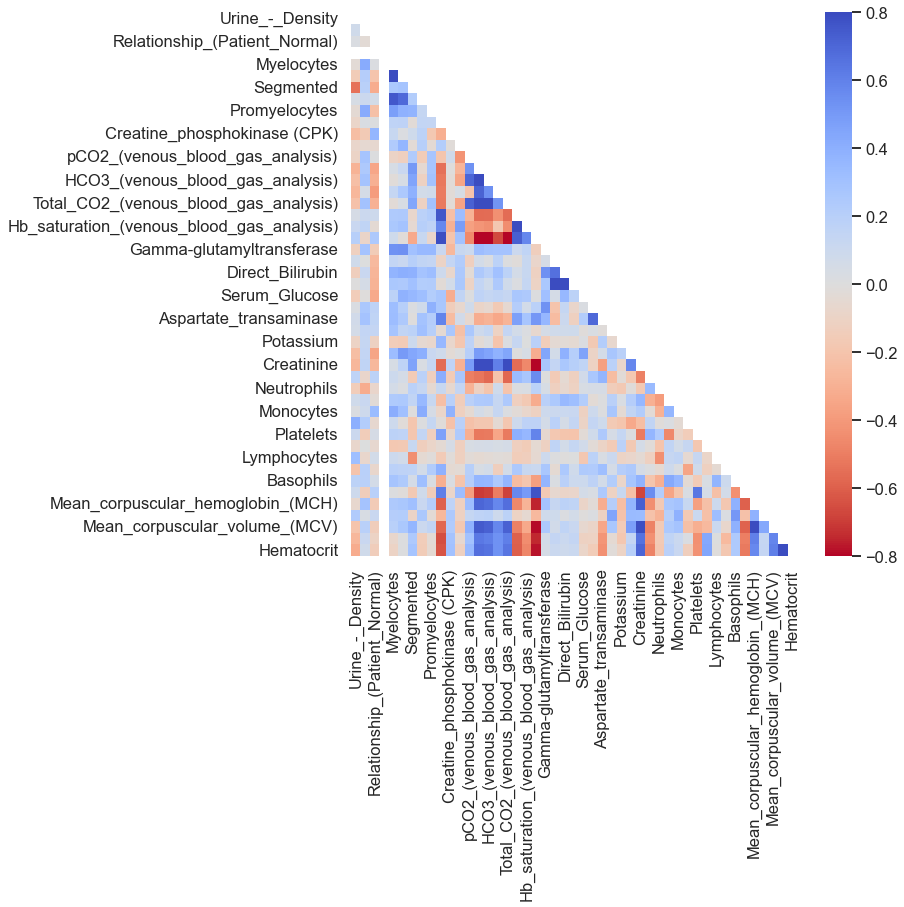

<IPython.core.display.Javascript object>

In [268]:
plt.figure(figsize=(10,10))
mask=np.triu(data[col11].corr())
sns.heatmap(data[col11].corr(),cmap='coolwarm_r',vmin=-0.8,vmax=0.8,mask=mask)


In [269]:
#remove correlated numeric features
X=data[col11]
y=data['SARS-Cov-2_exam_result']
X1=remove_correlated_features(X,0.7)

Metamyelocytes | Myelocytes | 0.84
Rods_# | Myelocytes | 0.75
HCO3_(venous_blood_gas_analysis) | pCO2_(venous_blood_gas_analysis) | 0.7
HCO3_(venous_blood_gas_analysis) | Base_excess_(venous_blood_gas_analysis) | 0.97
pH_(venous_blood_gas_analysis) | Base_excess_(venous_blood_gas_analysis) | 0.72
Total_CO2_(venous_blood_gas_analysis) | pCO2_(venous_blood_gas_analysis) | 0.72
Total_CO2_(venous_blood_gas_analysis) | Base_excess_(venous_blood_gas_analysis) | 0.96
Total_CO2_(venous_blood_gas_analysis) | HCO3_(venous_blood_gas_analysis) | 1.0
pO2_(venous_blood_gas_analysis) | Lactic_Dehydrogenase | 0.76
Hb_saturation_(venous_blood_gas_analysis) | pO2_(venous_blood_gas_analysis) | 0.89
Alkaline_phosphatase | Lactic_Dehydrogenase | 0.79
Alkaline_phosphatase | Base_excess_(venous_blood_gas_analysis) | 0.88
Alkaline_phosphatase | HCO3_(venous_blood_gas_analysis) | 0.86
Alkaline_phosphatase | Total_CO2_(venous_blood_gas_analysis) | 0.85
Alkaline_phosphatase | pO2_(venous_blood_gas_analysis) | 0.

<IPython.core.display.Javascript object>

In [270]:
col_cat=data.columns[data.columns.isin(categorical_features)]
fs = SelectKBest(score_func=chi2, k='all')
cat_chi=pd.DataFrame(fs.fit_transform(data[col_cat].drop('SARS-Cov-2_exam_result',axis=1),data['SARS-Cov-2_exam_result']),columns= fs.feature_names_in_)
cat_chi

,Urine_-_Protein,Urine_-_Esterase,Urine_-_Hyaline_cylinders,Urine_-_Granular_cylinders,Urine_-_Urobilinogen,Urine_-_pH,Urine_-_Hemoglobin,Urine_-_Bile_pigments,Urine_-_Color,Urine_-_Leukocytes,...,CoronavirusNL63,Adenovirus,Chlamydophila_pneumoniae,Parainfluenza_3,Influenza_B,Respiratory_Syncytial_Virus,Influenza_A,"Patient_addmited_to_intensive_care_unit_(1=yes,_0=no)","Patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","Patient_addmited_to_regular_ward_(1=yes,_0=no)"
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5640,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5641,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5642,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [271]:
X=pd.concat([X1,cat_chi],axis=1)
X.shape


(5644, 68)

<IPython.core.display.Javascript object>

In [272]:
onevalue=X.nunique().eq(1).astype('int').replace(0,np.nan).dropna().index.tolist()
X1=X.drop(onevalue,axis=1)
X1.shape

(5644, 55)

<IPython.core.display.Javascript object>

In [273]:
final=pd.concat([X1,y],axis=1)
final.to_csv('final_data.csv')

<IPython.core.display.Javascript object>

In [274]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Data columns (total 56 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Urine_-_Density                                        5644 non-null   float64
 1   Urine_-_Red_blood_cells                                5644 non-null   float64
 2   Relationship_(Patient_Normal)                          5644 non-null   float64
 3   Myelocytes                                             5644 non-null   float64
 4   Segmented                                              5644 non-null   float64
 5   Promyelocytes                                          5644 non-null   float64
 6   Lactic_Dehydrogenase                                   5644 non-null   float64
 7   Creatine_phosphokinase (CPK)                           5644 non-null   float64
 8   International_normalized_ratio_(INR)            

<IPython.core.display.Javascript object>

# EDA

In [275]:
imp=['Base_excess_(venous_blood_gas_analysis)',
 #'Patient_addmited_to_regular_ward_(1=yes,_0=no)',
 'Urea',
 'Monocytes',
 'Platelets',
 'Red_blood_Cells',
 'Lymphocytes',
 'Neutrophils',
 'Mean_platelet_volume_',
 'pCO2_(venous_blood_gas_analysis)',
 'Urine_-_Density',
 'Eosinophils',
 #'Rhinovirus_Enterovirus',
 'Lactic_Dehydrogenase',
 'Proteina_C_reativa_mg_dL',
 'Segmented',
 'Aspartate_transaminase',
 'Creatine_phosphokinase\xa0(CPK)']

<IPython.core.display.Javascript object>

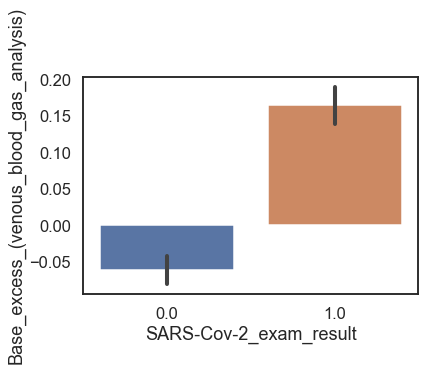

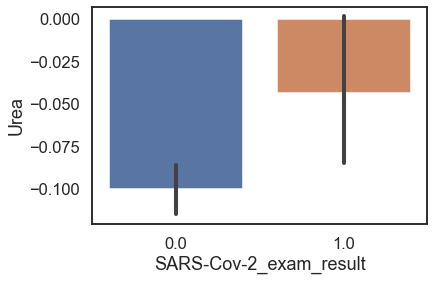

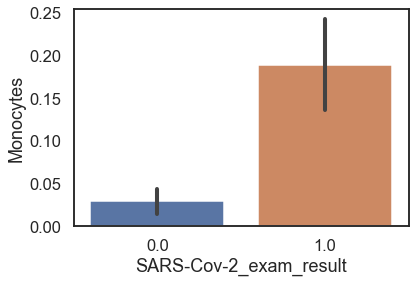

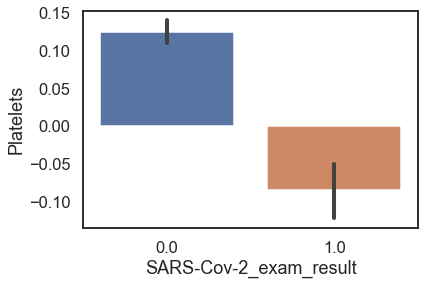

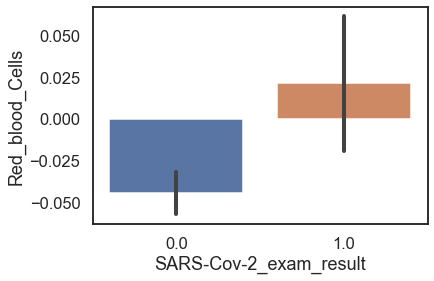

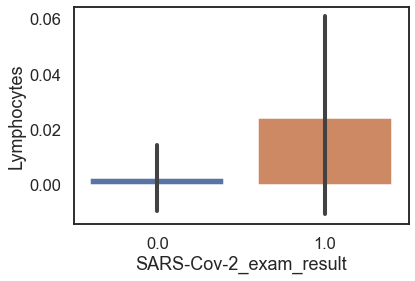

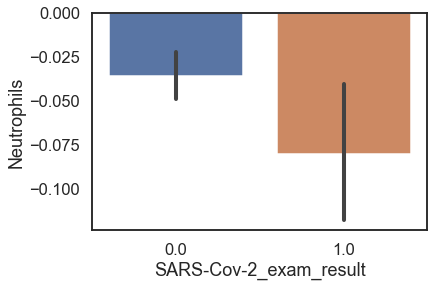

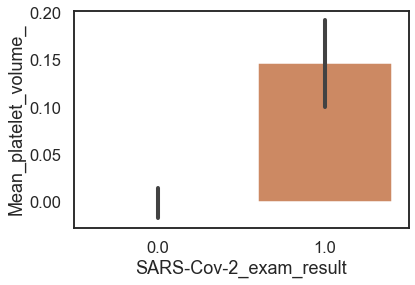

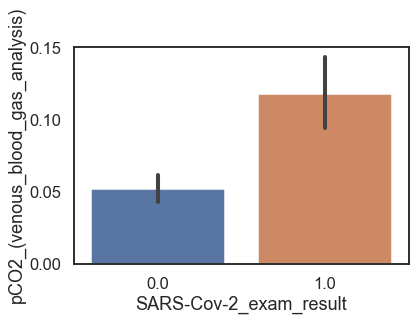

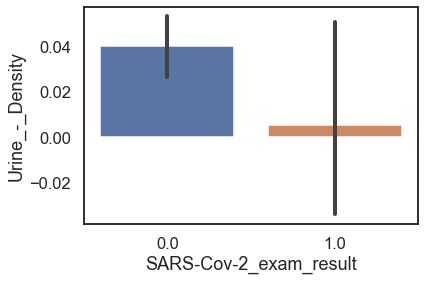

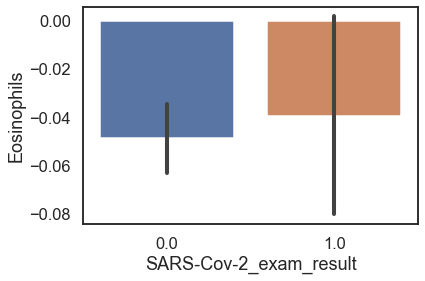

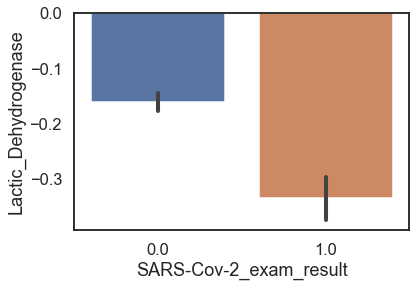

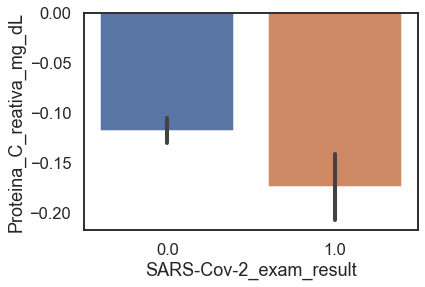

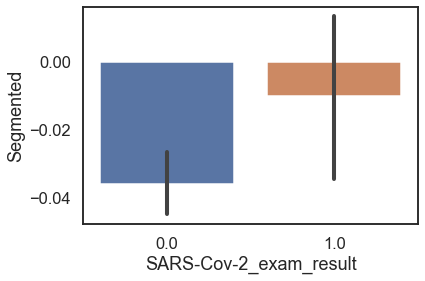

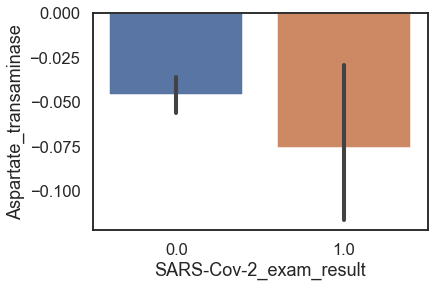

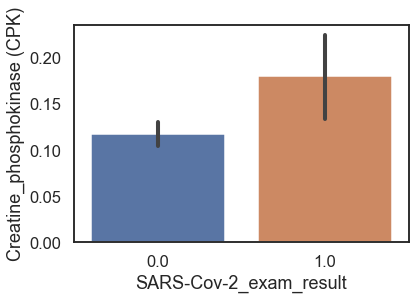

<IPython.core.display.Javascript object>

In [276]:
for col in imp:
    plt.figure()
    sns.barplot(data=final,y=col, x='SARS-Cov-2_exam_result')

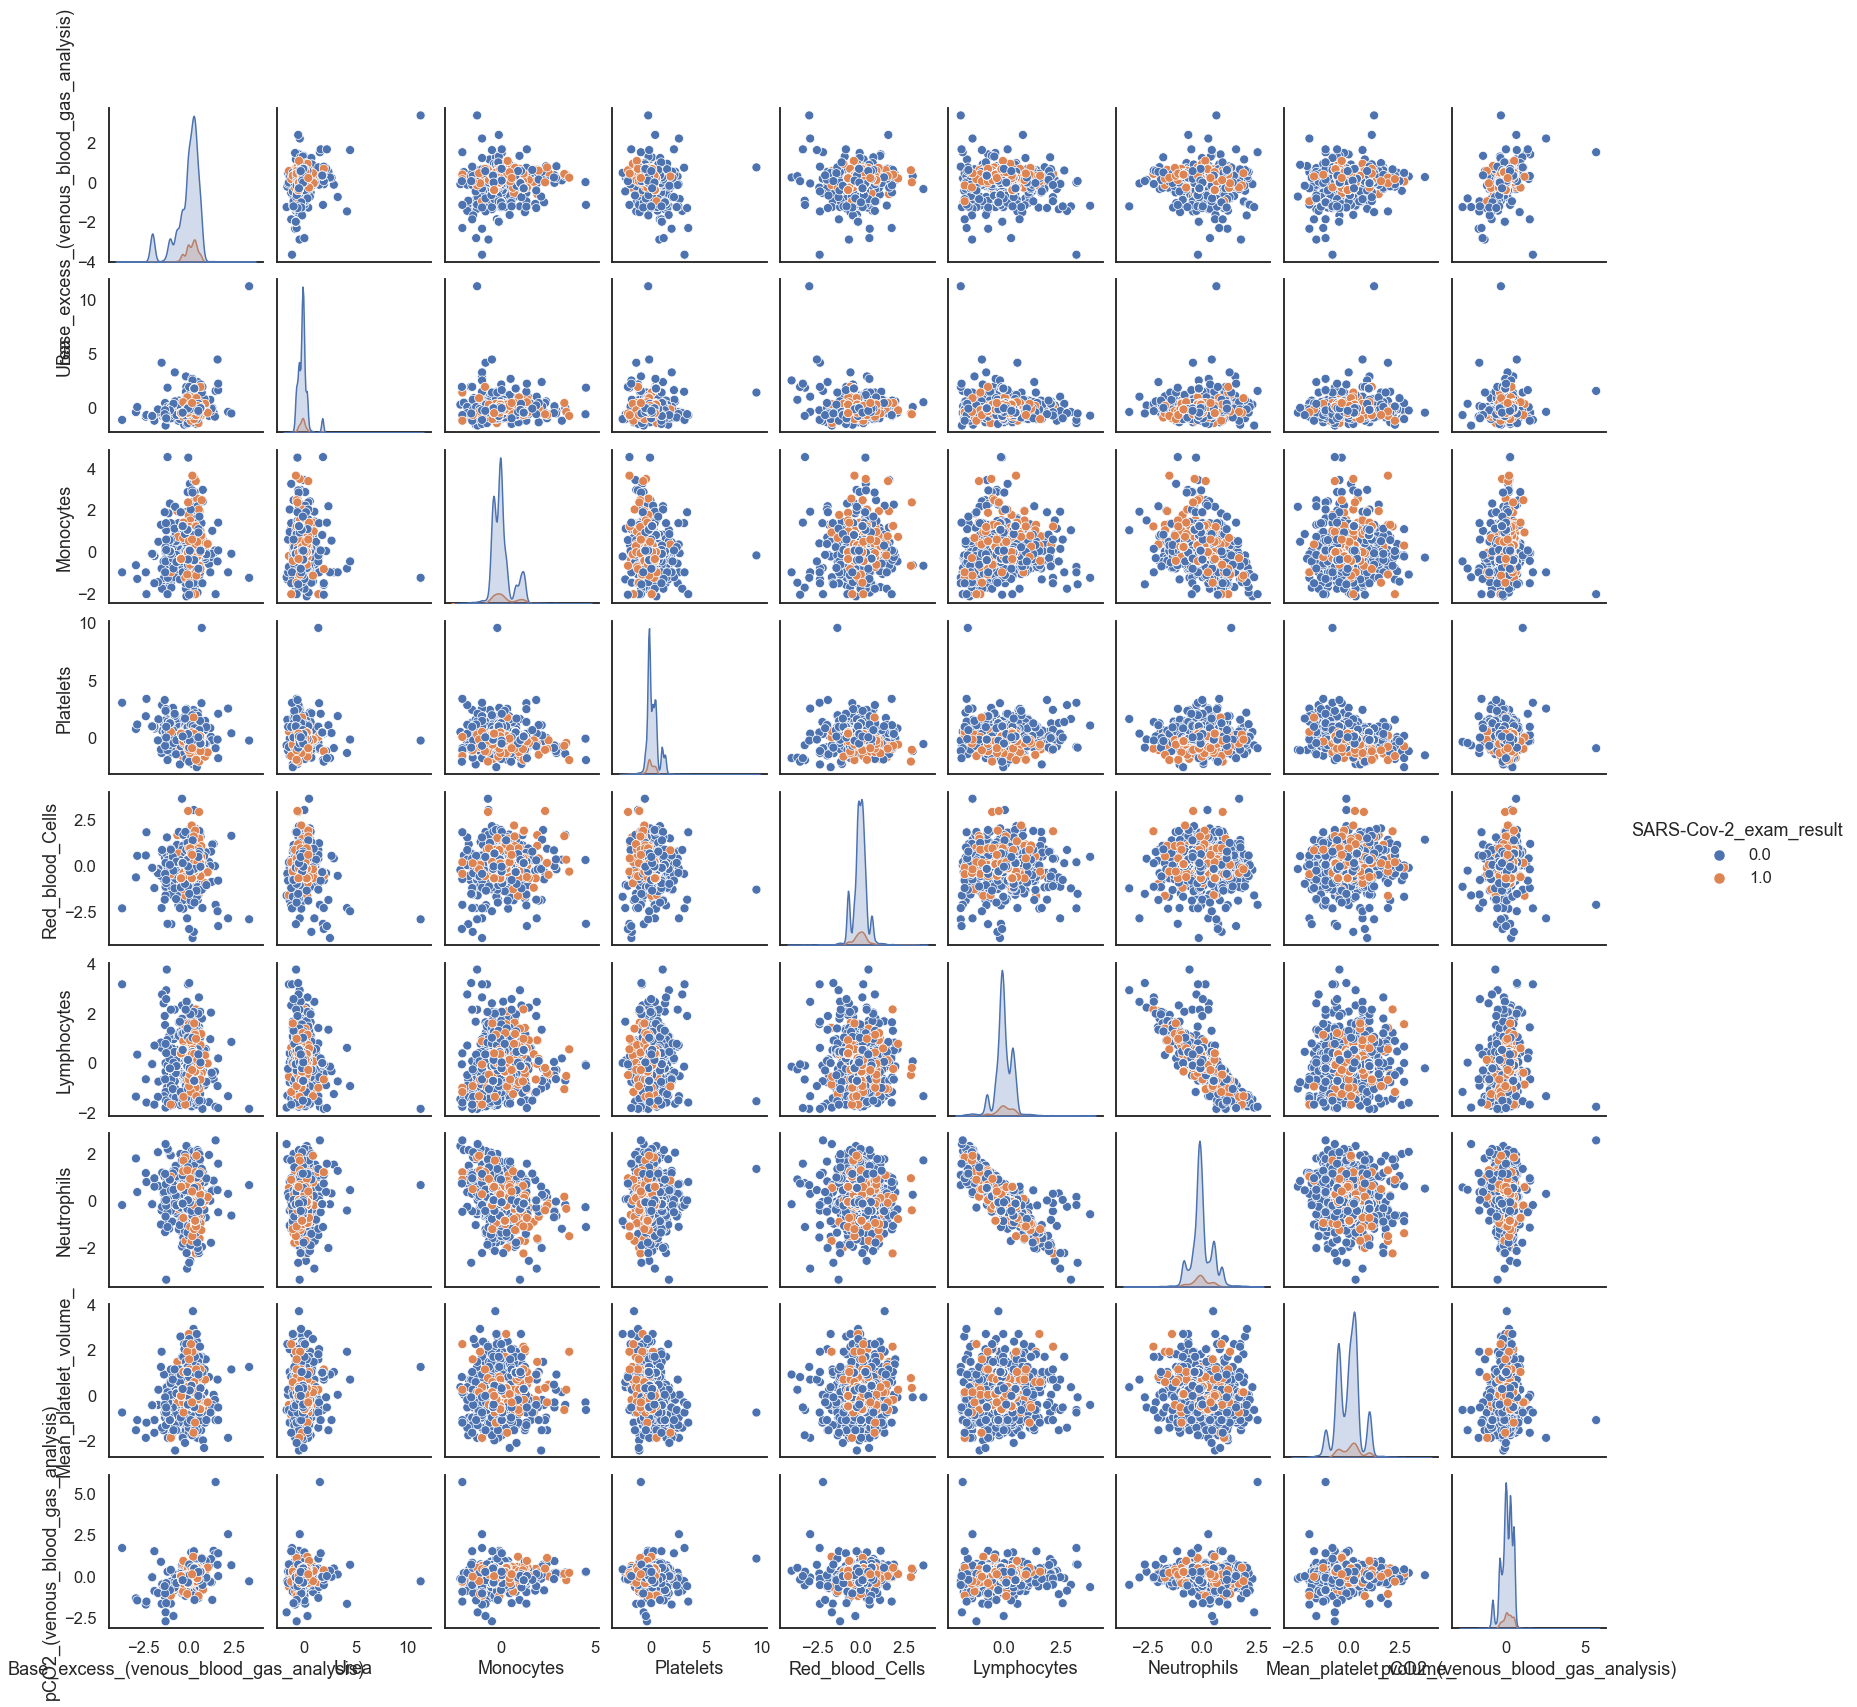

<IPython.core.display.Javascript object>

In [277]:
sns.pairplot(data=final,x_vars=imp[:9],y_vars=imp[:9],hue='SARS-Cov-2_exam_result')

In [278]:
def admission(df):
    if df['Patient_addmited_to_intensive_care_unit_(1=yes,_0=no)'] == 1:
        return 'Intensive_care'
    elif df['Patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)'] == 1:
        return 'Semi-intensive_care'
    elif df['Patient_addmited_to_regular_ward_(1=yes,_0=no)'] == 1:
        return 'Regular_ward'
    else:
        return 'No admission'
final['admission']= final.apply(admission,axis=1)  

<IPython.core.display.Javascript object>

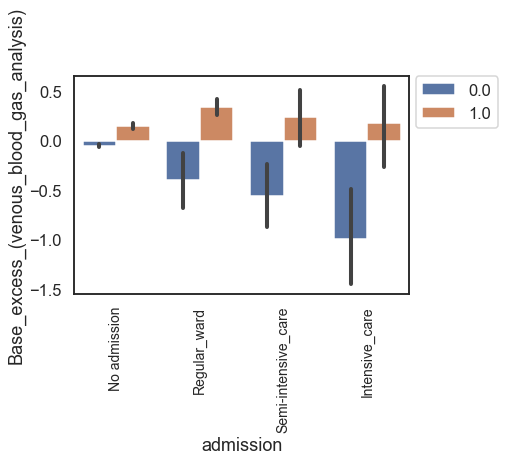

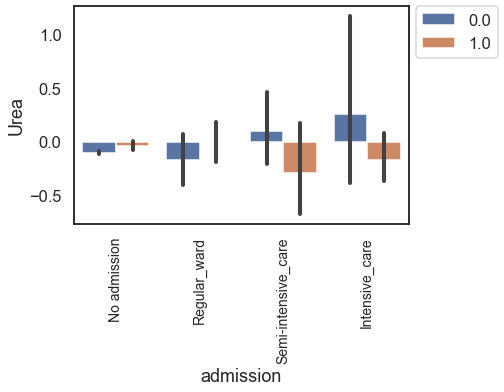

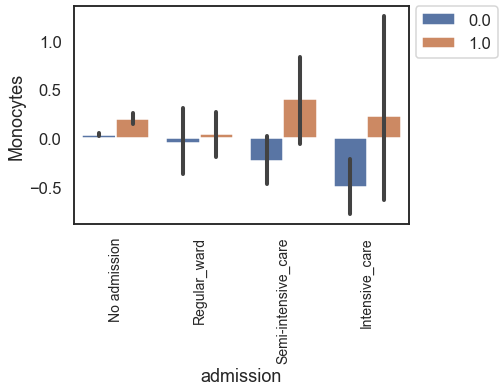

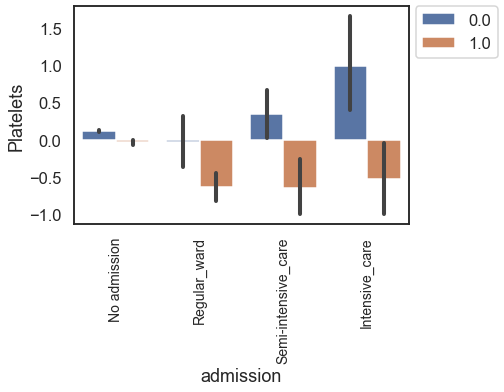

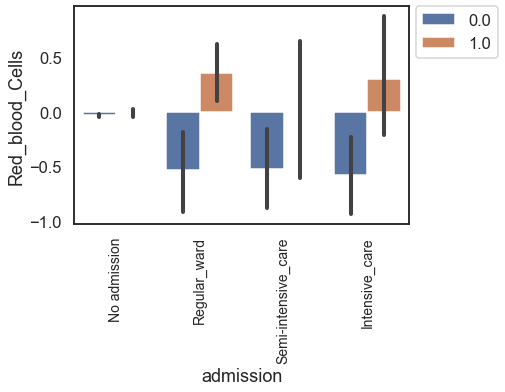

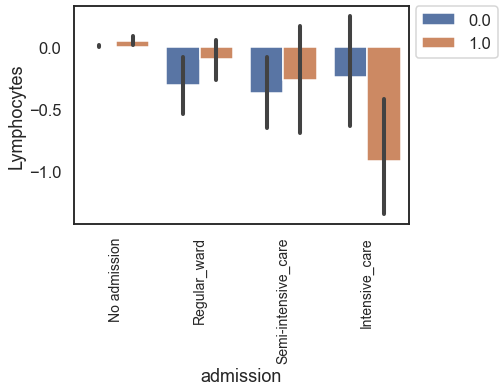

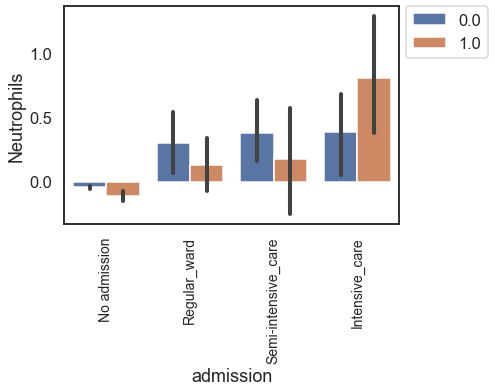

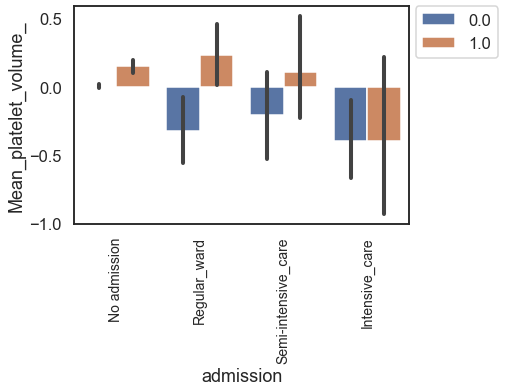

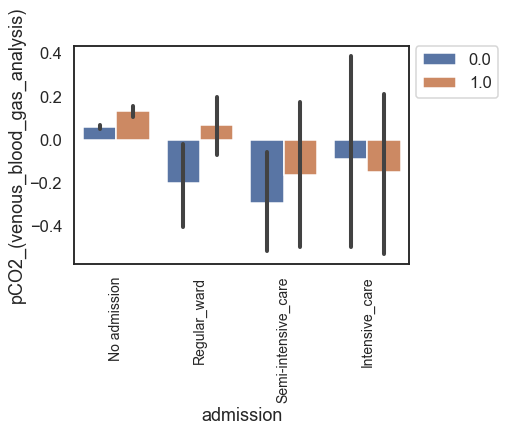

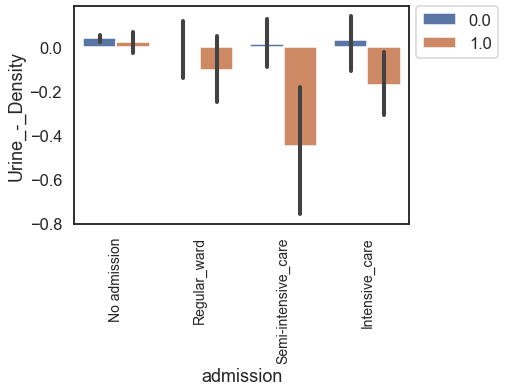

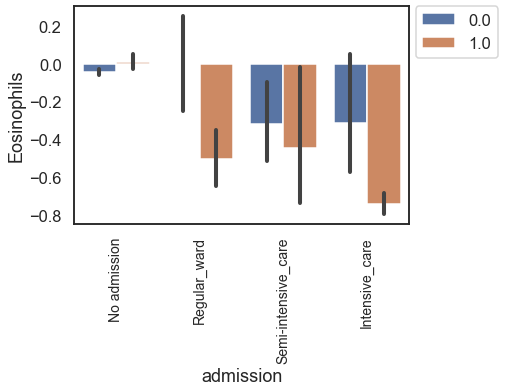

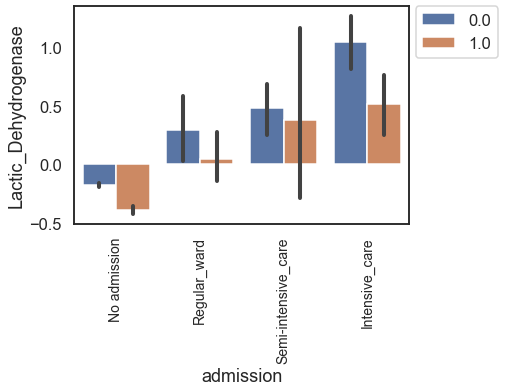

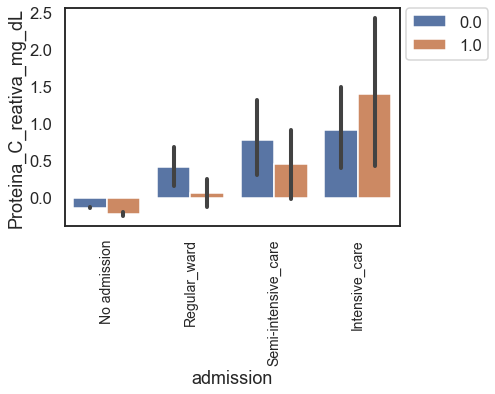

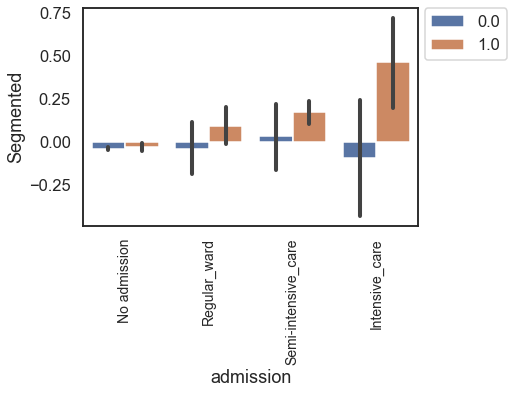

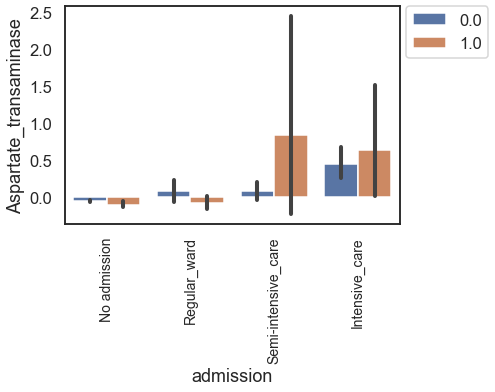

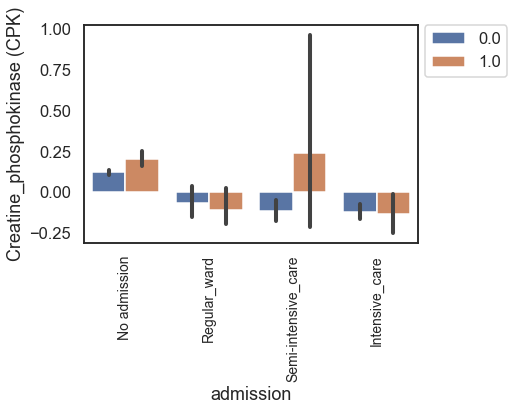

<IPython.core.display.Javascript object>

In [279]:
for col in imp:
    plt.figure()
    sns.barplot(data=final,x='admission',y=col,
                 order=['No admission','Regular_ward','Semi-intensive_care','Intensive_care'],hue='SARS-Cov-2_exam_result')
    plt.xticks(rotation=90,fontsize=14)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)